In [1]:
# uncomment to use specific GPU device
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=3

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import tensorflow
tensorflow.__version__

'1.15.0'

In [4]:
keras.__version__

'2.2.4'

In [5]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

## 1. Prepare the data

read the data from csv file:

In [6]:
CSV_PATH = "./data/data_for_gan_combined_ksttrain.csv"
PID_NAME = "e"

In [7]:
data_all_pids = pd.read_csv(CSV_PATH)

In [8]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def inv_sigmoid(y):
  return - np.log(1./y -1)


In [9]:
data_all_pids['GS0x7_invsigmoid'] = data_all_pids['GS0x7'].apply(inv_sigmoid)
data_all_pids.drop("GS0x7", axis=1, inplace=True)
#data_all_pids['GS0x7'] = data_all_pids['GS0x7_invsigmoid'].apply(sigmoid)

split columns in data to categories

In [10]:
vars_list = list(data_all_pids)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

In [11]:
in_columns = ['S6aux0','S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = vars_list_input
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)
MODEL_NAME = "GAN_Kramer_pid{}_ksttrain_nspdsigpnn".format(PID_NAME)

In [12]:
print(sigmoid(0.4), inv_sigmoid(sigmoid(0.4)))

0.598687660112452 0.39999999999999997


In [13]:
data_all_pids

,S6aux0,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux6,S0aux7,S0aux8,GS3x1,GS3x0,pid,GS0x7_invsigmoid
0,0.0,1.0,1.0,1.0,26.375467,16.0,6.016568,10.0,0.0,0.0,0.0,1.264371,3.0,2.446541,6827.50,1173.621349,-1.790293,-7.723530,k,2.068426
1,267.0,1.0,1.0,1.0,22.871672,19.0,6.469380,11.0,0.0,0.0,0.0,1.062400,3.0,3.423636,7980.12,519.651587,-7.590497,4.881044,k,0.338898
2,0.0,1.0,-999.0,1.0,17.784254,11.0,4.871000,11.0,0.0,0.0,0.0,0.842235,3.0,3.764144,40030.60,1855.418206,-1.106035,-0.573065,k,5.912364
3,0.0,1.0,1.0,1.0,18.192432,19.0,5.100973,5.0,0.0,0.0,0.0,0.876475,3.0,2.320766,23547.48,4580.477444,-4.106033,-7.859903,k,6.488049
4,0.0,1.0,1.0,1.0,7.370720,17.0,17.149891,13.0,0.0,0.0,0.0,0.868918,3.0,3.727386,19555.38,940.290479,-3.802394,-7.062094,k,5.399640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547057,0.0,1.0,-999.0,1.0,16.048597,19.0,2.233259,4.0,1.0,1.0,0.0,0.904995,3.0,2.204553,10001.99,2179.914562,6.866864,-4.565270,m,-4.063127
547058,334.0,1.0,1.0,1.0,14.667057,16.0,3.592739,3.0,1.0,1.0,1.0,0.795227,3.0,2.206241,28244.31,6145.662298,6.565184,-4.858411,m,-8.749974
547059,0.0,1.0,1.0,1.0,5.570735,7.0,12.265007,4.0,1.0,1.0,1.0,1.361961,3.0,2.646948,11022.24,1554.422989,9.305281,-3.080616,m,-2.176228
547060,277.0,1.0,1.0,1.0,20.214254,18.0,8.008176,9.0,1.0,1.0,1.0,0.913484,3.0,3.174114,47709.01,3984.475204,6.922552,-6.521602,m,-8.806909


In [14]:
BATCH_SIZE = int(1e4)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.3

In [15]:
def split_and_scale(data, robust_scaler=None, maxabs_scaler=None):
    # split data to train, val & test
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    
    # dropping pid column for applying preprocessing, will return it after
    pid_train = np.array(data_train["pid"])
    pid_val = np.array(data_val["pid"])
    pid_test = np.array(data_test["pid"])
    
    data_train.drop("pid", axis=1, inplace=True)
    data_val.drop("pid", axis=1, inplace=True)
    data_test.drop("pid", axis=1, inplace=True)
    
    # path to save preprocessor models to
    if not os.path.exists('gan_preprocessors'):
        os.makedrs('gan_preprocessors')
    
    # applying robust scaler
    if robust_scaler is None:
        robust_scaler = RobustScaler().fit(data_train)
        # save preprocessor model
        joblib.dump(robust_scaler, os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl")
        
    data_train = pd.DataFrame(robust_scaler.transform(data_train.values),
                              columns=data_train.columns)
    data_val = pd.DataFrame(robust_scaler.transform(data_val.values),
                            columns=data_val.columns)
    data_test = pd.DataFrame(robust_scaler.transform(data_test.values),
                            columns=data_test.columns)
    
    # applying max abs scaler
    if maxabs_scaler is None:
        maxabs_scaler = MaxAbsScaler().fit(data_train)
        # save preprocessor model
        joblib.dump(maxabs_scaler, os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
        
    data_train = pd.DataFrame(maxabs_scaler.transform(data_train),
                              columns=data_train.columns)
    data_val = pd.DataFrame(maxabs_scaler.transform(data_val),
                            columns=data_val.columns)
    data_test = pd.DataFrame(maxabs_scaler.transform(data_test),
                            columns=data_test.columns)
    
    # get back pid column
    data_train["pid"] = pid_train
    data_val["pid"] = pid_val
    data_test["pid"] = pid_test
    
    return data_train, data_val, data_test, robust_scaler, max_abs_scaler

In [16]:
# leave only data corresponding to one PID that we will build GAN for
data_pid = data_all_pids[data_all_pids.pid == PID_NAME]
try:
    robust_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl") 
    max_abs_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
except:
    robust_scaler, max_abs_scaler = None, None
data_train, data_val, data_test, robust_scaler, max_abs_scaler = split_and_scale(data_pid, robust_scaler, max_abs_scaler)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
# don't need this for GAN
data_train.drop("pid", axis=1, inplace=True)
data_val.drop("pid", axis=1, inplace=True)
data_test.drop("pid", axis=1, inplace=True)

In [18]:
aux_columns = vars_list_aux

Let's look at the distributions of the features:

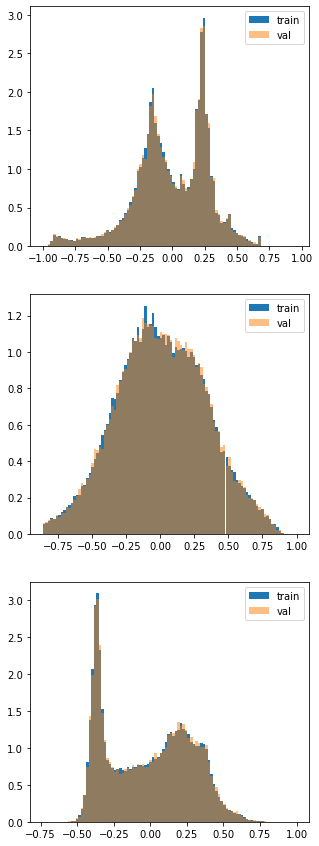

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
for feature_name, ax in zip(vars_list_input, axes):
    _, bins, _ = ax.hist(data_train[feature_name].values, bins=100, label="train", density=True)
    ax.hist(data_val[feature_name].values, bins=bins, label="val", alpha=0.5, density=True)
    ax.legend()
plt.show()

## 2. Building GAN

In [20]:
# rearrange columns to make them be in similar order
data_train = data_train[in_columns+out_columns]
data_val = data_val[in_columns+out_columns]
data_test = data_test[in_columns+out_columns]

In [21]:
tf.reset_default_graph()

In [22]:
def get_tf_dataset(dataset, batch_size):
    shuffler = tf.contrib.data.shuffle_and_repeat(dataset.shape[0])
    shuffled_ds = shuffler(tf.data.Dataset.from_tensor_slices(dataset))
    return tf.compat.v1.data.make_one_shot_iterator(shuffled_ds.batch(batch_size).prefetch(1)).get_next()

In [23]:
tf.compat.v1.disable_eager_execution()
def get_dense(num_layers):
    return [ll.Dense(80, activation='relu') for i in range(num_layers)]

CRAMER_DIM = 150

critic = keras.models.Sequential(
        [ll.InputLayer([OUT_DIM + IN_DIM])] + get_dense(3) +
            [ll.Dense(CRAMER_DIM)])
generator = keras.models.Sequential(
        [ll.InputLayer([LATENT_DIMENSIONS + IN_DIM])] + get_dense(3) +
            [ll.Dense(OUT_DIM)])

In [24]:
X_train_full = data_train[in_columns+out_columns]
X_train_input = data_train[in_columns]

X_train_input_tf1 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_input_tf2 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_full_tf = get_tf_dataset(X_train_full, BATCH_SIZE)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.data.experimental.shuffle_and_repeat(...)`.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [25]:
def cramer_critic(x, y):
    discriminated_x = critic(x)
    return tf.norm(discriminated_x - critic(y), axis=1) - tf.norm(discriminated_x, axis=1)

In [26]:
noise_1 = tf.random_normal([tf.shape(X_train_input_tf1)[0], LATENT_DIMENSIONS], name='noise1')
noise_2 = tf.random_normal([tf.shape(X_train_input_tf2)[0], LATENT_DIMENSIONS], name='noise2')

generated_out_1 = generator(tf.concat([noise_1, tf.cast(X_train_input_tf1, tf.float32)], axis=1))
generated_full_1 = tf.concat([tf.cast(X_train_input_tf1, tf.float32), generated_out_1], axis=1)

generated_out_2 = generator(tf.concat([noise_2, tf.cast(X_train_input_tf2, tf.float32)], axis=1))
generated_full_2 = tf.concat([tf.cast(X_train_input_tf2, tf.float32), generated_out_2], axis=1)

In [27]:
generator_loss = tf.reduce_mean(cramer_critic(tf.cast(X_train_full_tf, tf.float32), generated_full_2)
                                - cramer_critic(generated_full_1, generated_full_2))

In [28]:
with tf.name_scope("gradient_loss"):
    alpha = tf.random_uniform(shape=[tf.shape(X_train_full_tf)[0], 1], minval=0., maxval=1.)
    interpolates = alpha*tf.cast(X_train_full_tf, tf.float32) + (1.-alpha)*generated_full_1
    disc_interpolates = cramer_critic(interpolates, generated_full_2)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
    gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))

In [29]:
tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
lambda_tf = 20 / np.pi * 2 * tf.atan(tf.cast(tf_iter, tf.float32)/1e4)
critic_loss = lambda_tf*gradient_penalty - generator_loss
learning_rate = tf.train.exponential_decay(5e-4, tf_iter, 100, 0.99)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
critic_train_op = optimizer.minimize(critic_loss, var_list=critic.trainable_weights)
generator_train_op = tf.group(
    optimizer.minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [30]:
tf.summary.scalar("critic_loss", tf.reshape(critic_loss, []))
tf.summary.scalar("generator_loss", tf.reshape(generator_loss, []))
tf.summary.scalar("learning_rate", learning_rate)
tf.summary.scalar("lambda", lambda_tf)
merged_summary = tf.summary.merge_all()

In [31]:
# may vary, the more is the better
N_VAL = int(3e4)
validation_np = data_val.sample(N_VAL).values

In [32]:
var_init = tf.global_variables_initializer()
weights_saver = tf.train.Saver()

In [33]:
tf.get_default_graph().finalize()

## 3. Training GAN

In [34]:
LOGDIR = "./tensorboard_logdir"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = int(2e5)
VALIDATION_INTERVAL = 100
MODEL_WEIGHTS_FILE = "./weights/%s.ckpt" % MODEL_NAME
train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "test"))
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS)

In [35]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 80)                800       
_________________________________________________________________
dense_6 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 243       
Total params: 14,003
Trainable params: 14,003
Non-trainable params: 0
_________________________________________________________________


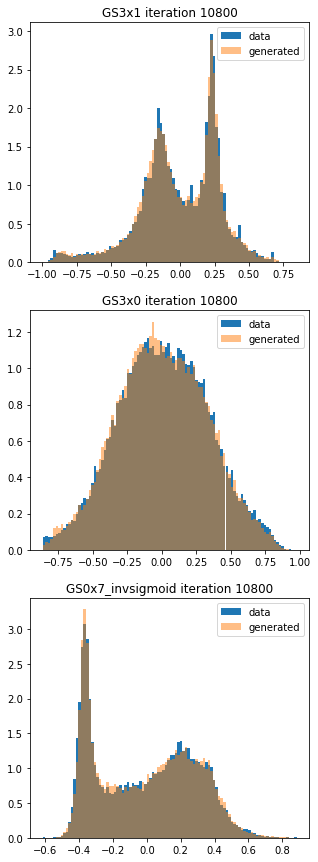

KeyboardInterrupt: 

In [36]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except Exception as e:
        print("Can't restore parameters: no file with weights")
        print(e)
    for i in range(TOTAL_ITERATIONS):
        for j in range(critic_policy(i)):
            sess.run(critic_train_op)
        train_summary, _, interation = sess.run([merged_summary, generator_train_op, tf_iter])
        train_writer.add_summary(train_summary, interation)
        
        # generate validation distribution and compare to the truth one
        if i % VALIDATION_INTERVAL == 0:
            print("i ",i)
            clear_output(False)
            test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
                X_train_input_tf1: validation_np[:, :len(in_columns)],
                X_train_input_tf2: validation_np[:, :len(in_columns)], X_train_full_tf: validation_np})
            try:
                fig, axes = plt.subplots(3, 1, figsize=(5, 3*5))
                for INDEX, ax in zip((0, 1, 2), axes):
                    _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
                    ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
                    ax.legend()
                    ax.set_title(out_columns[INDEX]+" iteration {}".format(i))
                plt.show()
                if not os.path.exists('plots'):
                    os.makedirs('plots')
                fig.savefig('./plots/{}.png'.format(MODEL_NAME))
            except Exception as e:
                print(e)
                weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
                continue
            
            test_writer.add_summary(test_summary, interation)
            weights_saver.save(sess, MODEL_WEIGHTS_FILE)

In [37]:
print("Number of iterations trained {}".format(i))

Number of iterations trained 10854


After training, let's check distribution generated by GAN for test examples:

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN V, pci bus id: 0000:05:00.0, compute capability: 7.0

INFO:tensorflow:Restoring parameters from ./weights/GAN_Kramer_pide_ksttrain_nspdsigpnn.ckpt


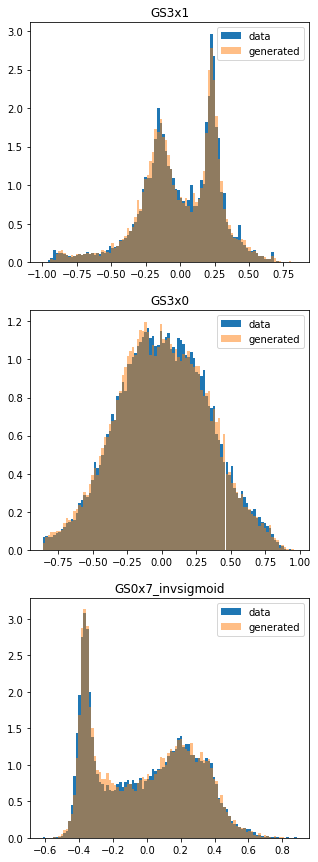

In [38]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
        X_train_input_tf1: data_test.values[:, :len(in_columns)],
        X_train_input_tf2: data_test.values[:, :len(in_columns)], X_train_full_tf: data_test})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

## 4. Save GAN weights and generated test data

In [39]:
# saving GAN weights to pickle format
import pickle
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    weights = sess.run(generator.weights)
    output = open('./weights/{}.pkl'.format(MODEL_NAME), 'wb')
    pickle.dump(weights, output)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN V, pci bus id: 0000:05:00.0, compute capability: 7.0

INFO:tensorflow:Restoring parameters from ./weights/GAN_Kramer_pide_ksttrain_nspdsigpnn.ckpt


In [40]:
print(MODEL_NAME)
try:
    robust_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl") 
    max_abs_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
except: print("fail")

GAN_Kramer_pide_ksttrain_nspdsigpnn


apply inverse transformations of the preprocessors on GAN output on test data:

In [41]:
test_transformed = max_abs_scaler.inverse_transform(np.concatenate([data_pid[vars_list_aux][:len(test_generated)].values, test_generated], axis=1))
test_transformed = robust_scaler.inverse_transform(test_transformed)

# save transformed test to csv
df_temp_enc = pd.DataFrame(test_transformed[:, -len(out_columns):], columns=out_columns)
df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, data_test[['S6aux0', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']]], axis=1), columns=out_columns+['S6aux0','S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])



In [42]:
#data_all_pids['GS0x7_invsigmoid'] = data_all_pids['GS0x7'].apply(inv_sigmoid)
#data_all_pids.drop("GS0x7", axis=1, inplace=True)
df_temp_full_enc.insert(len(out_columns)-1+1,'GS0x7',data_all_pids['GS0x7_invsigmoid'].apply(sigmoid))
#df_temp_full_enc['GS0x7'] = data_all_pids['GS0x7_invsigmoid'].apply(sigmoid)
df_temp_full_enc.drop("GS0x7_invsigmoid", axis=1, inplace=True)

In [43]:
df_temp_full_enc['pid'] = [PID_NAME]*len(df_temp_full_enc)
if not os.path.exists('data'):
    os.makedirs('data')
df_temp_full_enc.to_csv("./data/generated_pid{}.csv".format(MODEL_NAME), index=None)